# Book Genre Prediction from Plot Summaries

This notebook was created to train and test a deep learning model. The idea is to feed the deep learning model with book plot summaries and the models learns and predicts its genres.

* The book plot summaries used for this project was taken from http://www.cs.cmu.edu/~dbamman/booksummaries.html
* The environment used for training and testing was kaggle: https://www.kaggle.com/shwe87/

In [1]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if (device == "cuda"):
    free_gpu_cache()         

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7410 sha256=31129b9bade92b2b3f265363b4d93d7d9098b85cc4bba745c9e011aab8b4f385
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil


### Import all the libraries used.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import csv
import json
import matplotlib
import matplotlib.pyplot as plt

# Data cleaning and analysis
The first step is to understand the data and pre-process it and make it adequate for our neural network. The steps followed are:

1. Read from the text file which contains all the book summaries, genre, author, book title, etc. and visualize the data and save it to a dataframe.
2. Delete all the rows where the values for genre and summary are empty because these rows won't be any use for us.
3. The values in column Genres are in json format, convert them to list format. Each book has been given more than one genre.
4. To reduce complexity in the model, multilabel is discarded and will take in account only one label. To do so, a study was done to see which genres are the more frequent ones and only  these will be taken in account.

In [3]:
#Read from the text file which contains all the book summaries, genre, author, book title, etc. and visualize the data and save it to a dataframe.
book_summary_df = pd.read_csv("/kaggle/input/cmu-book-summary-dataset/booksummaries.txt", 
                              header=None,sep="\t", 
                              names=["Wikipedia ID", "Freebase ID", "Book Title", "Book Author", "Pub date","Genres","Summary"])
book_summary_df.head(5)

Wikipedia ID Freebase ID                                 Book Title  \
0           620     /m/0hhy                                Animal Farm   
1           843     /m/0k36                         A Clockwork Orange   
2           986     /m/0ldx                                 The Plague   
3          1756     /m/0sww  An Enquiry Concerning Human Understanding   
4          2080     /m/0wkt                       A Fire Upon the Deep   

       Book Author    Pub date  \
0    George Orwell  1945-08-17   
1  Anthony Burgess        1962   
2     Albert Camus        1947   
3       David Hume         NaN   
4     Vernor Vinge         NaN   

                                              Genres  \
0  {"/m/016lj8": "Roman \u00e0 clef", "/m/06nbt":...   
1  {"/m/06n90": "Science Fiction", "/m/0l67h": "N...   
2  {"/m/02m4t": "Existentialism", "/m/02xlf": "Fi...   
3                                                NaN   
4  {"/m/03lrw": "Hard science fiction", "/m/06n90...   

                                             Summary  
0   Old Major, the old boar on the Manor Farm, ca...  
1   Alex, a teenager living in near-future Englan...  
2   The text of The Plague is divided into five p...  
3   The argument of the Enquiry proceeds by a ser...  
4   The novel posits that space around the Milky ...

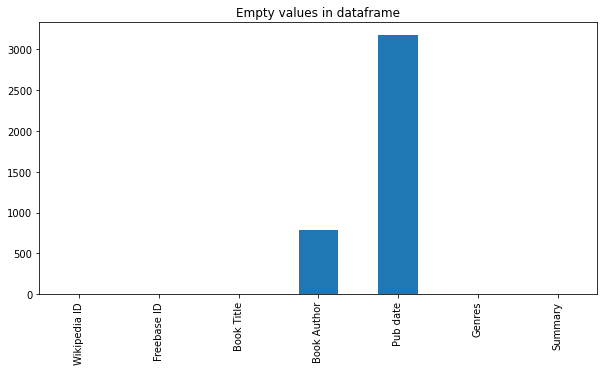

Wikipedia ID Freebase ID                      Book Title  \
0           620     /m/0hhy                     Animal Farm   
1           843     /m/0k36              A Clockwork Orange   
2           986     /m/0ldx                      The Plague   
4          2080     /m/0wkt            A Fire Upon the Deep   
5          2152     /m/0x5g  All Quiet on the Western Front   

            Book Author    Pub date  \
0         George Orwell  1945-08-17   
1       Anthony Burgess        1962   
2          Albert Camus        1947   
4          Vernor Vinge         NaN   
5  Erich Maria Remarque  1929-01-29   

                                              Genres  \
0  [Roman à clef, Satire, Children's literature, ...   
1  [Science Fiction, Novella, Speculative fiction...   
2  [Existentialism, Fiction, Absurdist fiction, N...   
4  [Hard science fiction, Science Fiction, Specul...   
5                          [War novel, Roman à clef]   

                                             Summary  
0   Old Major, the old boar on the Manor Farm, ca...  
1   Alex, a teenager living in near-future Englan...  
2   The text of The Plague is divided into five p...  
4   The novel posits that space around the Milky ...  
5   The book tells the story of Paul Bäumer, a Ge...

In [4]:
#Delete all the rows where summary and genre are NaN.
book_summary_df = book_summary_df.dropna(subset=['Genres', 'Summary'])
plt.figure(figsize=(10,5))
book_summary_df.isna().sum().plot(kind='bar', title='Empty values in dataframe') #There are no empty values in Genres and Summary
plt.show()
# Convert the genre from json format to list format.
try:
    book_summary_df['Genres'] = book_summary_df['Genres'].map(lambda genre : list(json.loads(genre).values()))
except TypeError:
    print("Already converted to list.")
book_summary_df.head(5)

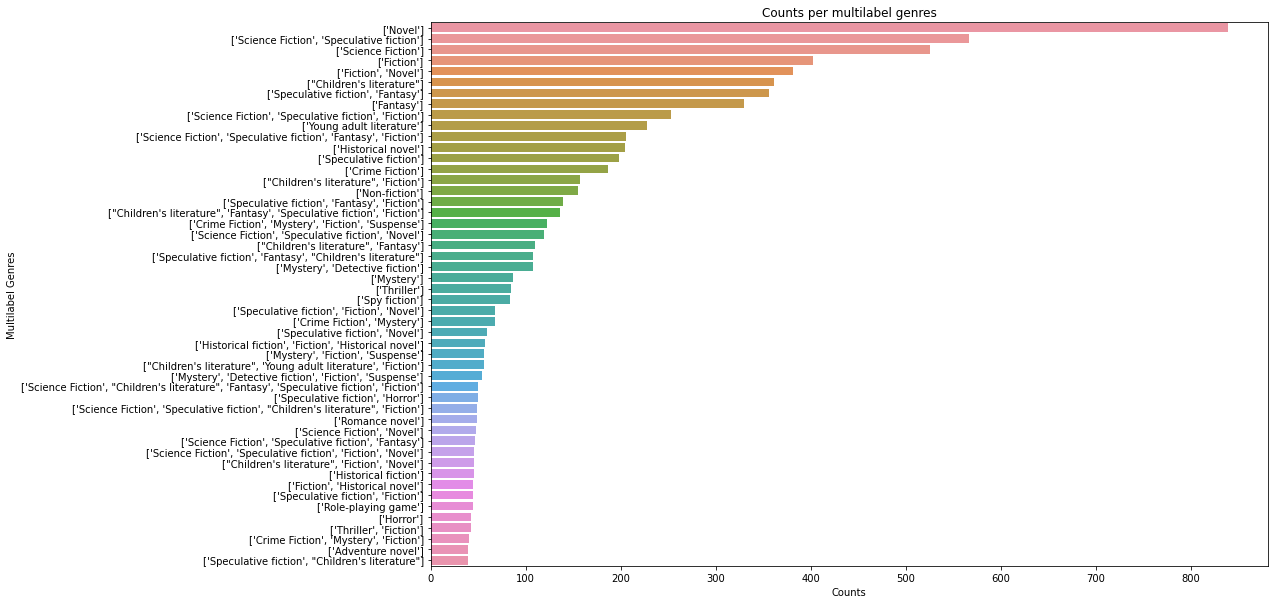

In [5]:
import seaborn as sns
counts = {}
g = book_summary_df['Genres'].map(str).to_numpy()
for i in g:
    #''.join(map(lambda x: chr(ord(x) + 1), sampleStr))
    #gn = ' '.join(map(lambda x: str(x) + ' |', i))
    if i in counts.keys():
        counts[i] += 1
    else:
        counts[i] = 1
df = pd.DataFrame({"Genre": list(counts.keys()),
                   "Counts": list(counts.values())})
g = df.nlargest(columns=["Counts"], n=50)
plt.figure(figsize=(15,10)) 
ax = sns.barplot(data=g, x= "Counts", y = "Genre") 
ax.set(xlabel = 'Counts', ylabel = 'Multilabel Genres')
plt.title('Counts per multilabel genres')
plt.show()

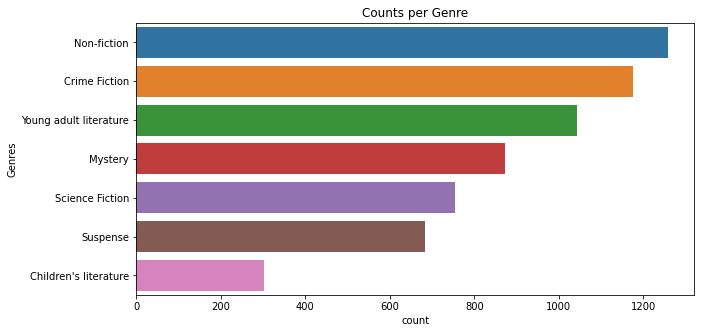

In [6]:
import seaborn as sns
# ../input/book-summaries-from-goodreads
gd_df = pd.read_csv('../input/load-summaries/book_summaries_goodreads.csv')
gd_df.rename(columns={"book_title": "Book Title", "book_authors": "Book Author", "book_desc": "Summary", "genres": "Genres"}, inplace=True)
plt.figure(figsize=(10,5))
sns.countplot(data=gd_df, order=gd_df.Genres.value_counts().index, y='Genres')
plt.title("Counts per Genre")
plt.show()

# Data Analysis
In the following plot, Fiction is the genre with most plots. For this project, the first 10 genres with largest counts have been taken.

As the neural network doesn't understand strings and will be feeding on numbers. Each of these genres have been encoded with a number & saved in a dictionary.

1. Crime Fiction
2. Science Fiction
3. Speculative Fiction
4. Fantasy
5. Children's Literature
6. Mystery
7. Young adult literature
8. Suspense
9. Non-fiction

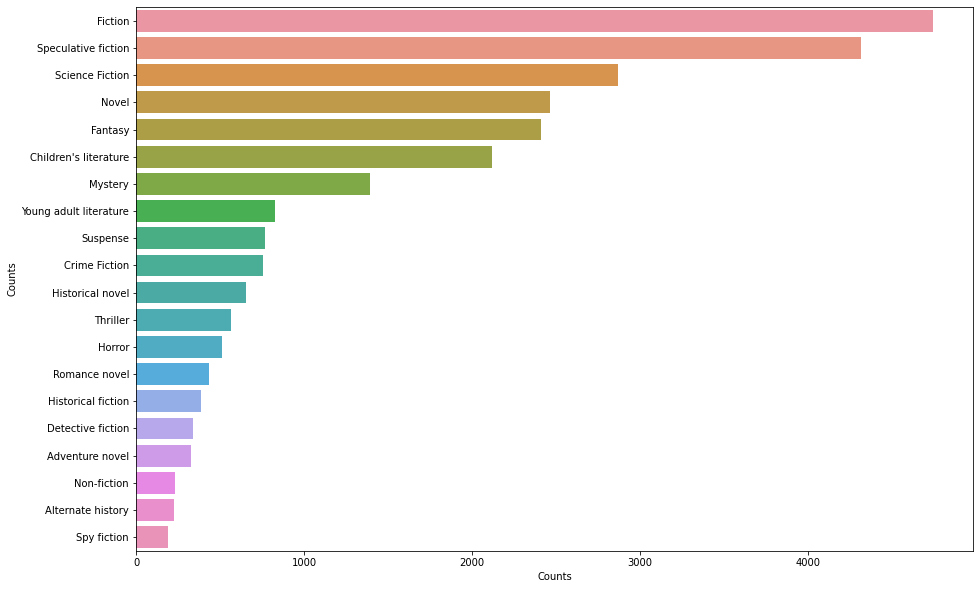

In [7]:
def genre_analysis(b_df):
    all_genres = b_df.Genres
    count_genre = {}
    for genres in all_genres:
        for genre in genres:
            if genre in count_genre.keys():
                count_genre[genre] += 1
            else:
                count_genre[genre] = 1
    df = pd.DataFrame({"Genre": list(count_genre.keys()),
                   "Counts": list(count_genre.values())})
    g = df.nlargest(columns=["Counts"], n=20)
    plt.figure(figsize=(15,10)) 
    ax = sns.barplot(data=g, x= "Counts", y = "Genre") 
    ax.set(ylabel = 'Counts') 
    plt.show()
genre_analysis(book_summary_df)

In [8]:
from booksummarydataset import VALID_GENRES as valid_genres
from booksummarydataset import N_CLASSES as n_classes
from booksummarydataset import get_genre

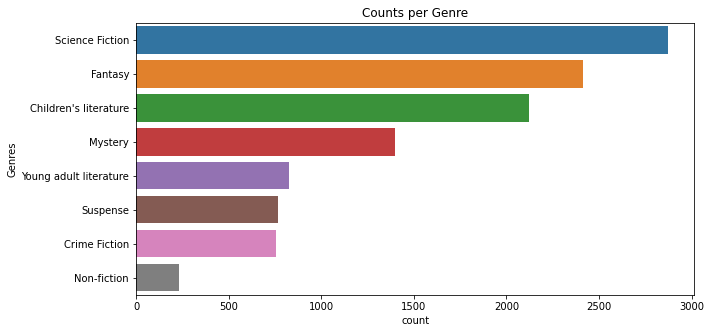

In [9]:
# Will only keep the genre if in the dictionary valid_genres
book_summary_df=book_summary_df.explode("Genres").loc[book_summary_df.explode("Genres")["Genres"].isin(valid_genres)]
plt.figure(figsize=(10,5))
sns.countplot(data=book_summary_df, order=book_summary_df.Genres.value_counts().index, y='Genres')
plt.title("Counts per Genre")
plt.show()

### Cleaning
As one book can have more than one valid labels, the duplicates are eliminated. For example, if a book "Example" had ["Fiction", "Crime Fiction", "Novel", "Fantasy"] then the cell above created four lines for each of these genres for the book "Example". In order to have only one genre per book (and not to confuse the neural network), the duplicates have been deleted and only the first occurrance has been saved.

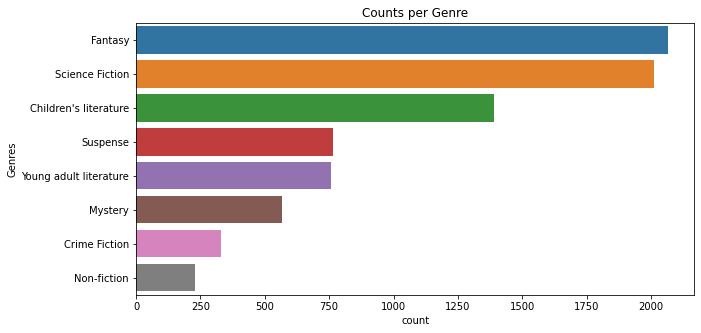

In [10]:
book_summary_df = book_summary_df.drop_duplicates(subset=['Wikipedia ID'], keep='last')
plt.figure(figsize=(10,5))
sns.countplot(data=book_summary_df, order=book_summary_df.Genres.value_counts().index, y='Genres')
plt.title("Counts per Genre")
plt.show()

In [11]:
# Drop some damples from the CMU database to use the summaries from goodreads database as well.
sci_fi_df = book_summary_df[book_summary_df['Genres'] == 'Science Fiction']
book_summary_df = book_summary_df.drop(sci_fi_df.index[-600:], axis=0)

In [12]:
main_df = pd.DataFrame({"Book Title": book_summary_df["Book Title"],
                        "Book Author": book_summary_df["Book Author"],
                        "Summary": book_summary_df["Summary"],
                        "Genres": book_summary_df["Genres"]
                       })
main_df.shape

(7519, 4)

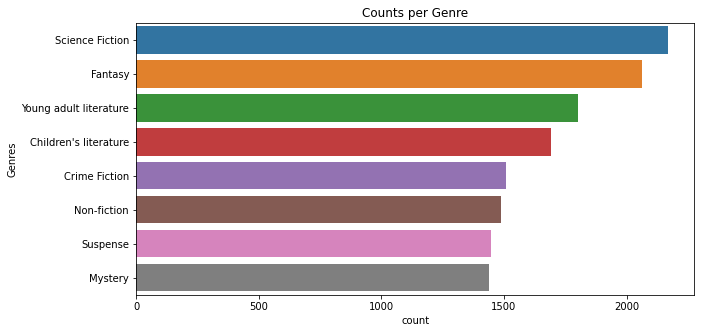

In [13]:
book_summary_df = pd.concat([main_df, gd_df], axis=0)
plt.figure(figsize=(10,5))
sns.countplot(data=book_summary_df, order=book_summary_df.Genres.value_counts().index, y='Genres')
plt.title("Counts per Genre")
plt.show()

In [14]:
 book_summary_df['String Counts'] = book_summary_df.Genres.str.len()

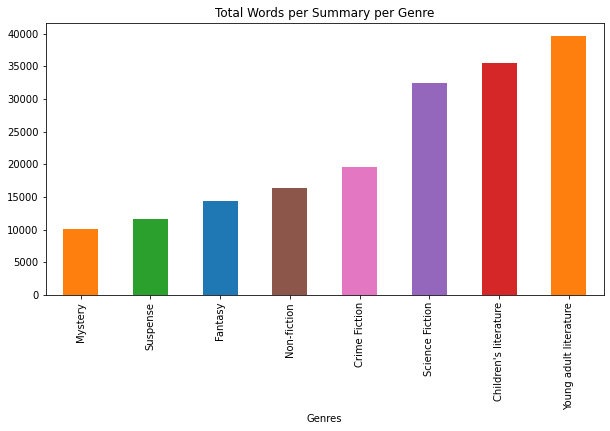

In [15]:
plt.figure(figsize=(10,5))
df = book_summary_df.groupby(['Genres'])['String Counts'].sum().reset_index()
df.sort_values(['String Counts'], ascending=True).head(10).plot(kind='bar', y='String Counts', x='Genres',
                legend=False, color=['tab:orange', 'tab:green', 'tab:blue', 'tab:brown', 'tab:pink', 'tab:purple','tab:red'], ax=plt.gca())
plt.title("Total Words per Summary per Genre")
plt.show()

In [16]:
book_summary_df.to_csv('./book_summaries.csv')

# Word Cloud

Create word cloud for each genre. Use all the stopwords from the library wordcloud and nltk library. Also the word "one" is added to it as a stopword.

In [17]:
from wordcloud import WordCloud,STOPWORDS

In [18]:
from nltk.corpus import stopwords
STOPWORDS.update(["one"])
w = stopwords.words('english')
STOPWORDS.update(w)

In [19]:
from PIL import Image
def make_plot_words(genre):
    des = " ".join(plot for plot in book_summary_df[book_summary_df["Genres"]==genre].Summary)
    mask = np.array(Image.open("../input/images/old-book.jpg"))
    wordcloud = WordCloud(width=1600, height=800, mask=mask, mode="RGBA", background_color='white', max_words=1000).generate(des)
    plt.figure(figsize=(15,10))
    #plt.gcf().set_facecolor("black")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(label=" Word Cloud for {}".format(genre), fontsize=40)
    plt.tight_layout(pad=0)
    #plt.savefig("./{}.png".format(genre), format="png")
    plt.show()

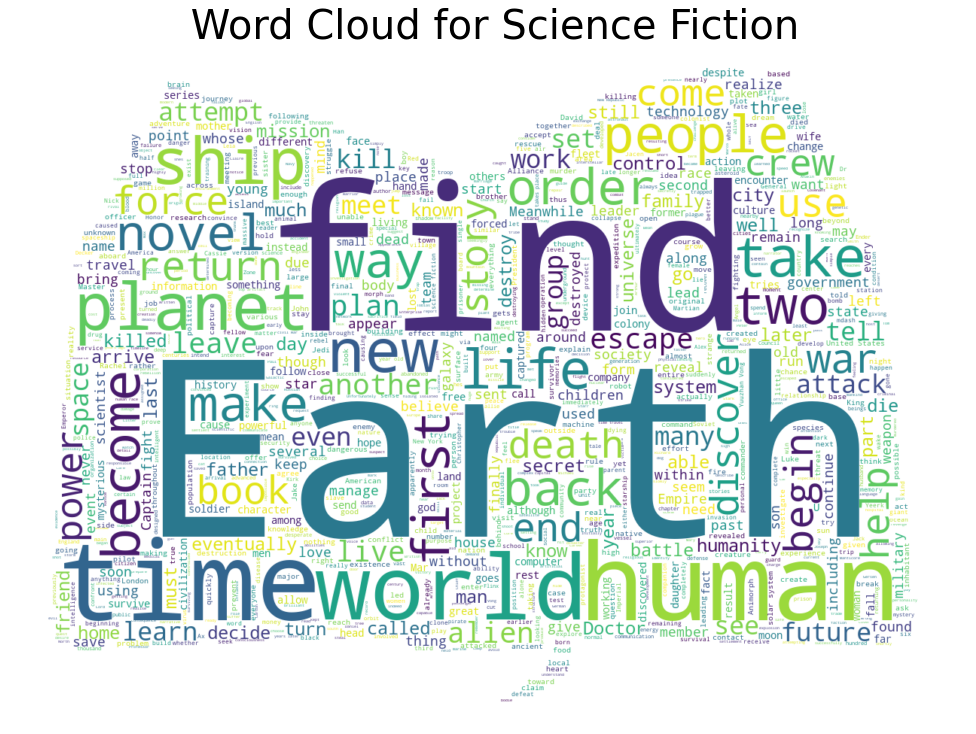

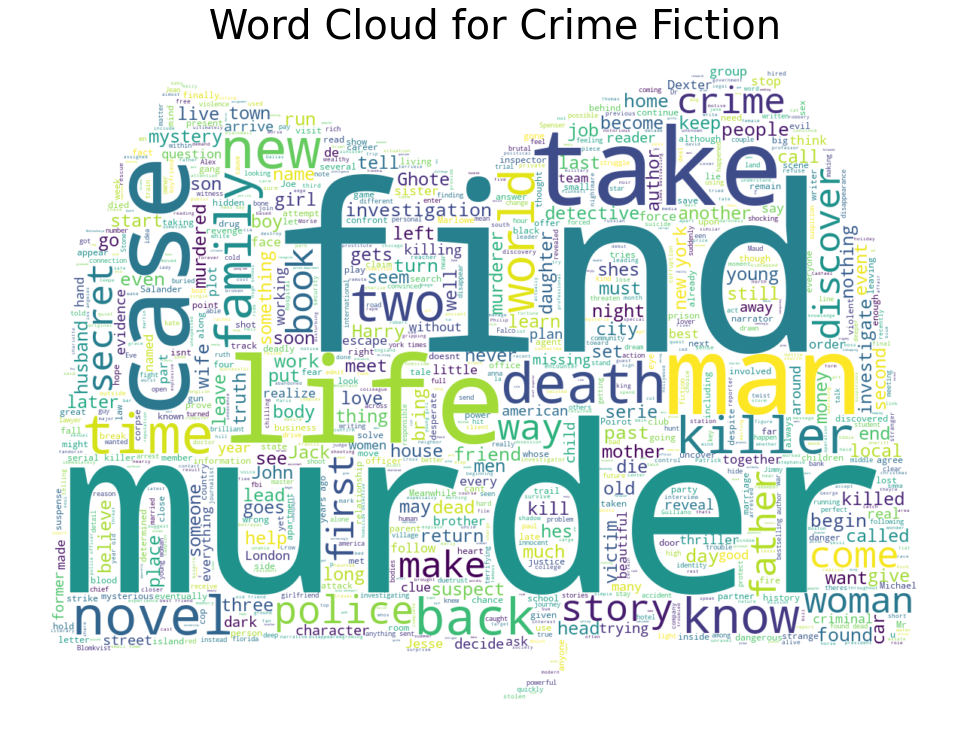

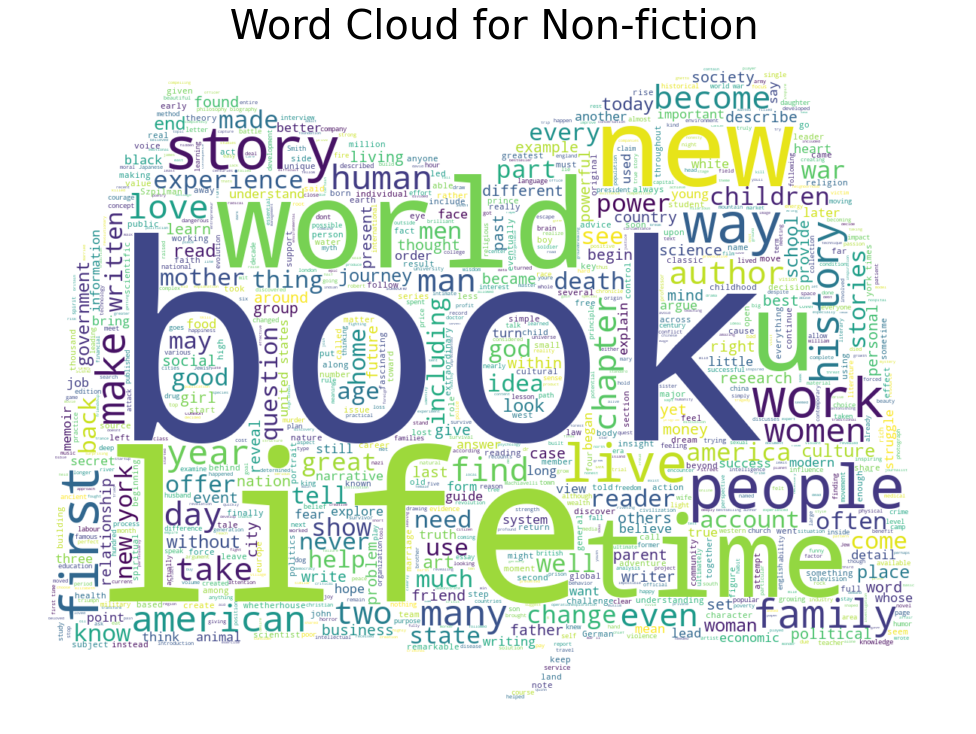

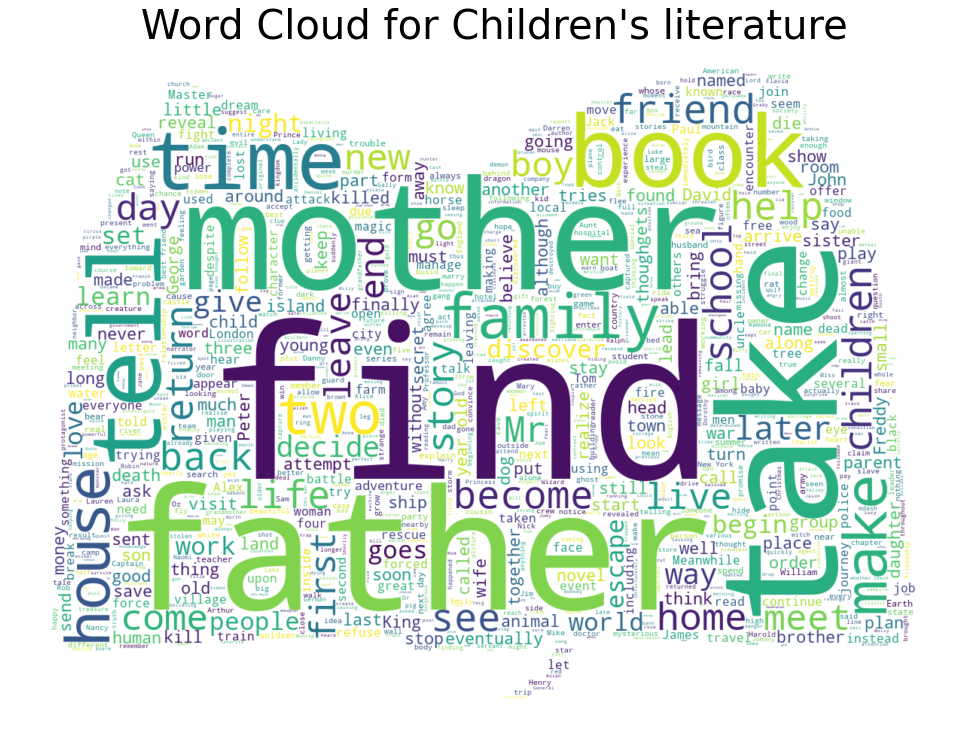

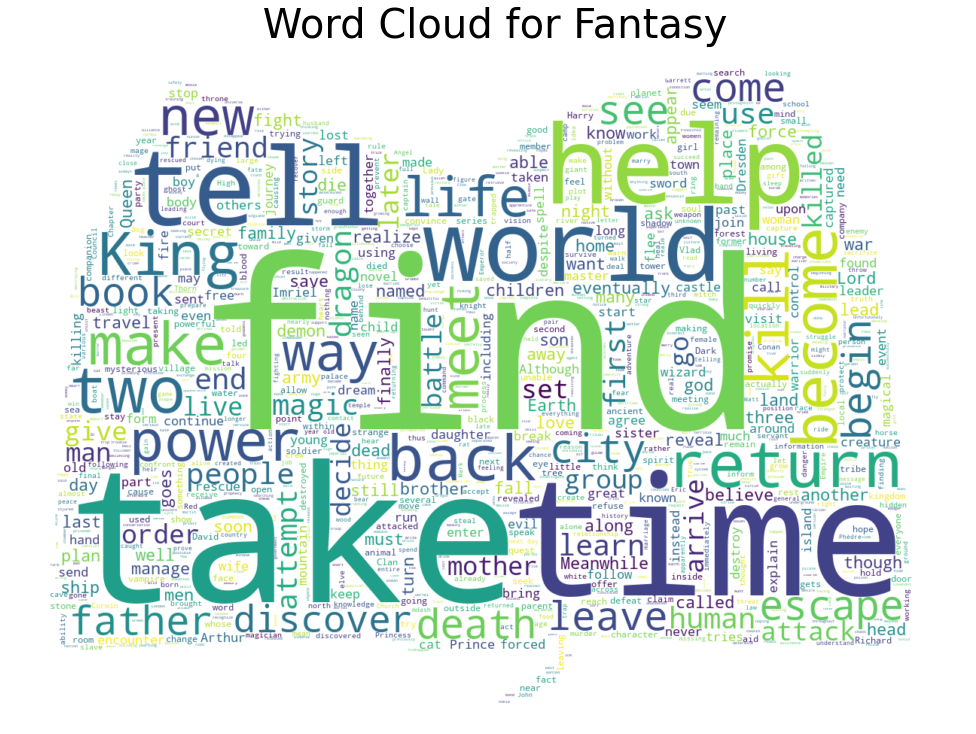

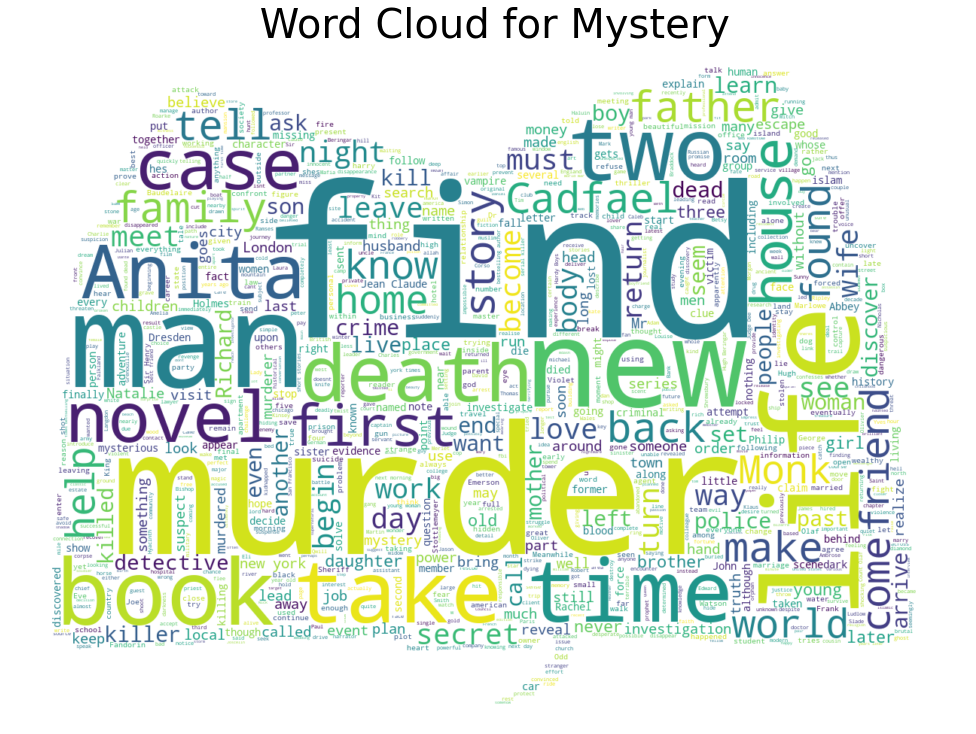

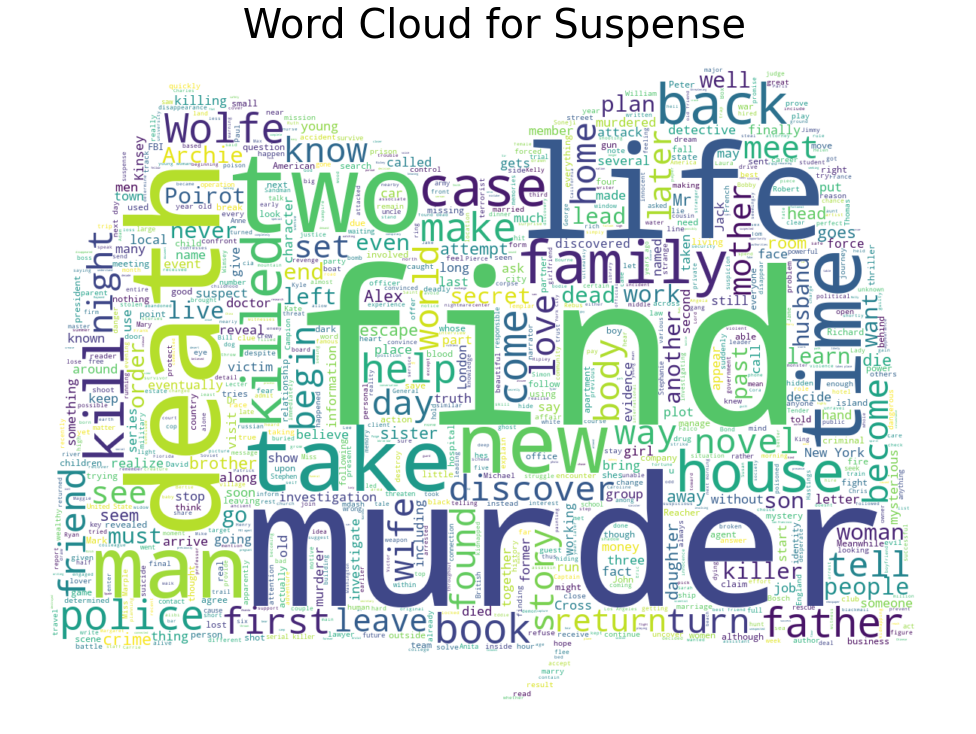

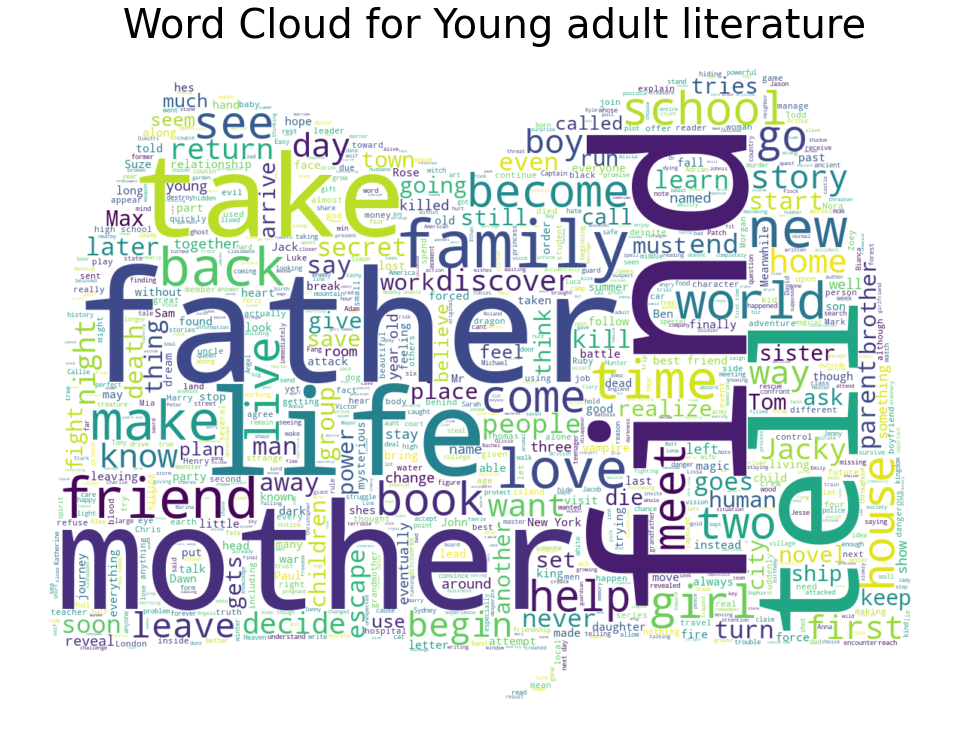

In [20]:
for i, g in zip(range(len(valid_genres.keys())), valid_genres.keys()):
    make_plot_words(genre=g)

# Data pre-processing

As a neural network understands only numbers, the plot summaries will also have to be converted to the proper form to feed into the network. At this point, to get the correct format of the input, the architecture of the network needs to be clear. The proposed archiecture for the prediction of book genre will be as shown in the following figure:

1. The first step will be to pass the words to an embedding layer for dimensionality reduction because a plot summary can have more than 5K words as seen before.
2. The second layer will have recurrent network cells. LSTM or GRU. The recurrent networks work very well for time-sequence data. Sentences or human language follow a sequence so this type of network has been chosen.
3. For classification a fully connected network laye has been added.
4. A softmax function is used to classify the genre with the output from the neural network.

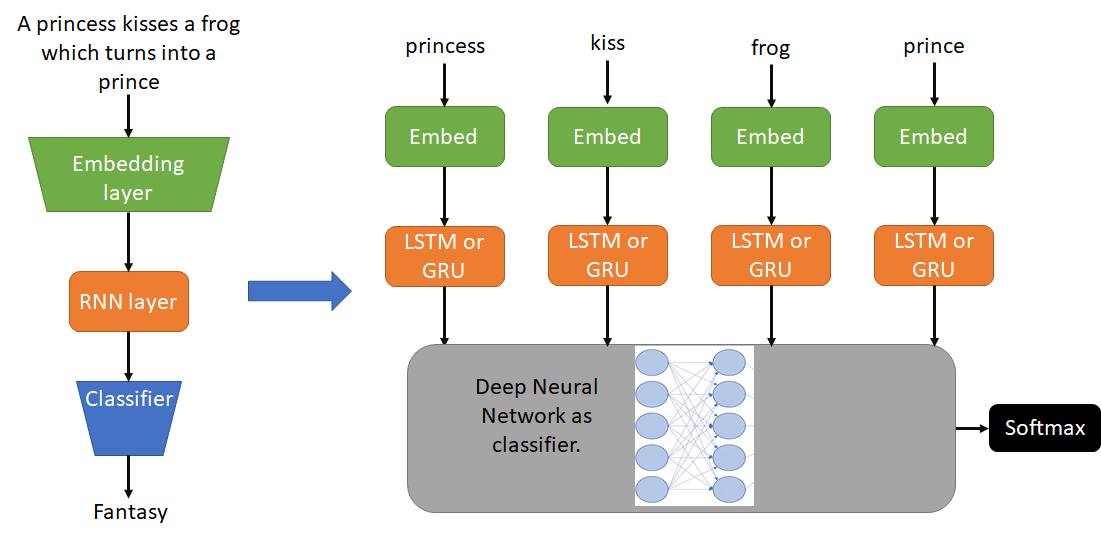


**Embedding Layer:** Each word needs to be encoded with an integer. Before doing so, only relevant data should be saved.

- Get rid of periods and puntuation as these won't be of any use to the neural network.
- Turn all string to lowercase.
- Stem the words.
- And then split each sentence or summary to words.

In [21]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
import re


In [22]:
import string
# Function to convert text to words.
def summary_to_words(summary):
    nltk.download('stopwords', quiet=True)
    table = str.maketrans(dict.fromkeys(string.punctuation))
    text = summary.translate(table)
    #stemmer = PorterStemmer()
    text = re.sub(r"[^a-zA-Z0-9\s]"," ", text.lower())
    words = text.split()
    words = [w for w in words if w not in stopwords.words("english")]
    #words = [PorterStemmer().stem(w) for w in words]
    return words

In [23]:
import pickle
def preprocess_data(data_train, data_test, data_val, labels_train, labels_test, labels_val):
    
    """Convert each summary to words"""

    # Preprocess training and test data to obtain words for each summary
    words_train = [summary_to_words(summary) for summary in data_train]
    words_val = [summary_to_words(summary) for summary in data_val]
    words_test = [summary_to_words(summary) for summary in data_test]

    return words_train, words_val, words_test, labels_train, labels_val, labels_test       

# Transform the data
For feature representation of the data, the words will be represented as integers. The words which appears infrequently won't be of much value. To deal with long and short summaries, a fixed sequence length will be indicated. When the summary is shorter than this length, it will be padded by zeros.
The words that occur infrequently will be categorized as INFREQ and will be agrouped as one category and will be labeled as 1. The fixed size is also because the recurrent network needs a fixed length for all the inputs.

In [24]:
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

vocab_size = 10000


def dummy(x):
    return x

def build_dict(data, vocab_size = vocab_size):
    """Construct and return a dictionary mapping each of the most frequently appearing words to a unique integer."""
    
    # Determine how often each word appears in `data`. `data` is a list of sentences and that a
    # sentence is a list of words.
    vectorizer = CountVectorizer(max_features=vocab_size, preprocessor=dummy, tokenizer=dummy)
    features = vectorizer.fit_transform(data)
    words = vectorizer.get_feature_names()
    counts = np.asarray(features.toarray().sum(axis=0))
    word_count = dict(zip(words, counts)) # A dict storing the words that appear in the summary along with how often they occur
    
    # sorted_words[0] is the most frequently appearing word and
    # sorted_words[-1] is the least frequently appearing word.
    
    sorted_words = sorted(word_count, key=word_count.get, reverse=True)
    
    word_dict = {} # This is what we are building, a dictionary that translates words into integers
    for idx, word in enumerate(sorted_words[:vocab_size - 2]): # The -2 is so that we save room for the 'no word'
        word_dict[word] = idx + 2                              # 'infrequent' labels
        
    return (word_dict, word_count)

# Training, Validation and Test
Split the data into training, validation and testing sets.
1. Training data --> 85% of the total
2. Validation data --> 10.49% of the total
3. Testing data --> 4.50% of the total

In [25]:
from sklearn.model_selection import train_test_split

book_summary_train, book_summary_valid_test = train_test_split(book_summary_df, test_size=0.15, random_state=42, stratify=book_summary_df['Genres'])
book_summary_valid, book_summary_test = train_test_split(book_summary_valid_test, test_size=0.3, random_state=42, stratify=book_summary_valid_test['Genres'])

In [26]:
book_summary_train.to_csv('./book_summaries_train.csv')
book_summary_valid.to_csv('./book_summaries_valid.csv')
book_summary_test.to_csv('./book_summaries_test.csv')

In [27]:
def get_dataset(df):
    x = df.Summary.to_numpy()
    y = df.Genres.to_numpy()
    y = [valid_genres[l] for l in y]
    return (x, y)

In [28]:
#Split to train, validation and test data

(train_x, train_y) = get_dataset(book_summary_train)
(val_x, val_y) = get_dataset(book_summary_valid)
(test_x, test_y) = get_dataset(book_summary_test)

print("Total dataset = {},{}".format(len(book_summary_df.Summary), len(book_summary_df.Genres)))
print("Training dataset = {},{}".format(len(train_x), len(train_y)))
print("Validation dataset = {},{}".format(len(val_x), len(val_y)))
print("Testing dataset = {},{}".format(len(test_x), len(test_y)))

Total dataset = 13608,13608
Training dataset = 11566,11566
Validation dataset = 1429,1429
Testing dataset = 613,613


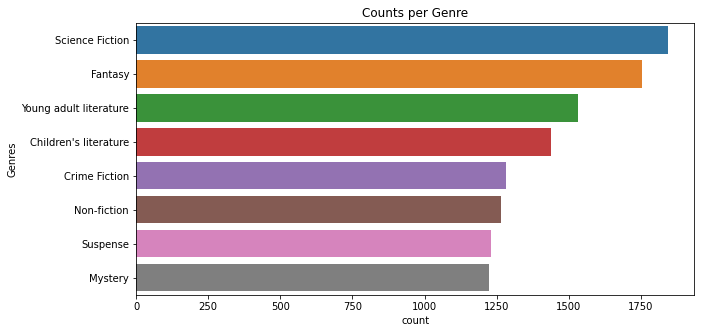

In [29]:
plt.figure(figsize=(10,5))
sns.countplot(data=book_summary_train, order=book_summary_train.Genres.value_counts().index, y='Genres')
plt.title("Counts per Genre")
plt.show()

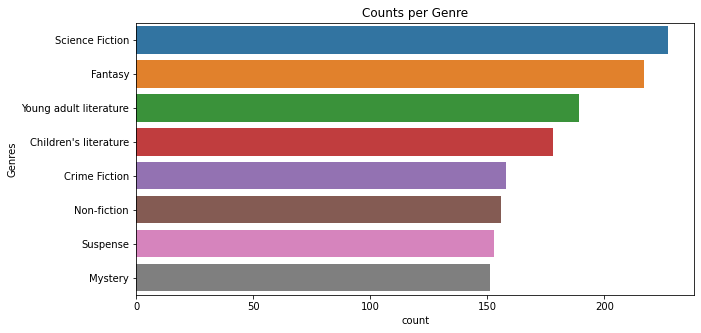

In [30]:
plt.figure(figsize=(10,5))
sns.countplot(data=book_summary_valid, order=book_summary_valid.Genres.value_counts().index, y='Genres')
plt.title("Counts per Genre")
plt.show()

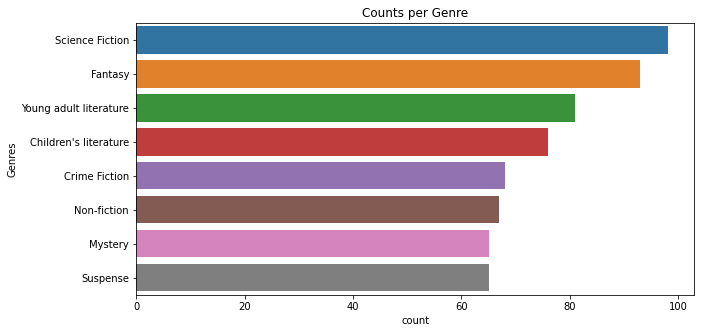

In [31]:
plt.figure(figsize=(10,5))
sns.countplot(data=book_summary_test, order=book_summary_test.Genres.value_counts().index, y='Genres')
plt.title("Counts per Genre")
plt.show()

In [32]:
#Preprocess data
#train_x, val_x, test_x, train_y, val_y, test_y = preprocess_data(train_x, test_x, val_x, train_y, test_y, val_y)
#print(len(train_x))
#print(len(val_x))
#print(len(test_x))

In [33]:
#(word_dict, word_count)= build_dict(train_x)
#print(len(word_dict))

In [34]:
#with open(os.path.join("./", 'word_dict.pkl'), "wb") as f:
#        pickle.dump(word_dict, f)

In [35]:
#word_count_df = pd.DataFrame({'Word': list(word_count.keys()), 
#                              'Count': list(word_count.values())})

In [36]:
#import matplotlib.pyplot as plt
#import seaborn as sns
#g = word_count_df.nlargest(columns="Count", n = 100) 
#plt.figure(figsize=(12,15)) 
#ax = sns.barplot(data=g, x= "Count", y = "Word") 
#ax.set(ylabel = 'Count') 
#plt.title("Word Dictionary Count - Top 100")
#plt.show()

In [37]:
#Calculate the mean number of words per each summary
#summary_len = [len(s) for s in book_summary_df['Summary']]
#print("Average words per summary {:.3f}".format(np.mean(summary_len))) #Average of 2631 words per summary
#print("Maximum words in a summary {}".format(np.max(summary_len)))
#print("Minimum words in a summary {}".format(np.min(summary_len)))

In [38]:
#print(list(word_dict)[:5]) #the 5 most frequently used word
#print(list(word_dict)[-5:]) #the 5 least frequently used words
#print(word_count['new'])
#print(len(word_dict))

# Convert and pad

Convert words to int as per the word_dict and create a fixed size. For example if fixed size is 10 and a summary is of size 5 then it will be padded to have length of 10. If a summary is of length 15, then it will be truncated and only be taken in account 10.

In [39]:
def convert_and_pad(word_dict, sentence, pad=1000):
    NOWORD = 0 # 0 to represent the 'no word' category
    INFREQ = 1 # 1 to represent the infrequent words, i.e., words not appearing in word_dict
    
    working_sentence = [NOWORD] * pad
    
    for word_index, word in enumerate(sentence[:pad]):
        if word in word_dict:
            working_sentence[word_index] = word_dict[word]
        else:
            working_sentence[word_index] = INFREQ
            
    return working_sentence, min(len(sentence), pad)

def convert_and_pad_data(word_dict, data, pad=1000):
    result = []
    lengths = []
    
    for sentence in data:
        converted, leng = convert_and_pad(word_dict, sentence, pad)
        result.append(converted)
        lengths.append(leng)
        
    return np.array(result), np.array(lengths)

In [40]:
def conv_pad_and_save(data, labels, pad, save_file,word_dict=word_dict):
    x, x_len = convert_and_pad_data(word_dict, data, pad=pad)
    print(x.shape)
    print(len(labels))
    pd.concat([pd.DataFrame(labels), pd.DataFrame(x)], axis=1) \
        .to_csv(save_file, header=None, index=False)    

NameError: name 'word_dict' is not defined

In [41]:
#pad=1500
#conv_pad_and_save(word_dict=word_dict, data=train_x, labels=train_y,pad=pad,save_file='./train.csv')
#conv_pad_and_save(word_dict=word_dict, data=val_x, labels=val_y,pad=pad,save_file='./val.csv')
#conv_pad_and_save(word_dict=word_dict, data=test_x, labels=test_y,pad=pad,save_file='./test.csv')